In [1]:
import TurbPy as tb
from TurbPy.imports import *

In [ ]:
# deck = 'KH_Lv1di/'
# deck = 'KH_new/'
# deck = 'KH_400ppc_200wci2/'
deck = 'KH_200ppc_200wci/'
# deck = 'KH_beta0.1/'
# deck = 'turb2/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

lx_de = info['Lx/de']
ly_de = info['Ly/de']

lx_di = info['Lx/di']
ly_di = info['Ly/di']

nx = int(info['nx'])
ny = int(info['ny'])

lxr_di = np.linspace(0, lx_di, nx)
lyr_di = np.linspace(0, ly_di, ny)

lxr_de = np.linspace(0, lx_de, nx)
lyr_de = np.linspace(0, ly_de, ny)

In [ ]:
# t = 5295
# ds = tb.load_vars(dirs, t, 'electron')

t = times[1087]
ds = tb.load_vars(dirs, t, 'electron')
print(twci[1087])

150.12209160000003


In [ ]:
dbx = ds['cbx'] - np.mean(ds['cbx'])
dby = ds['cby'] - np.mean(ds['cby'])
dbz = ds['cbz'] - np.mean(ds['cbz'])

dex = ds['ex'] - np.mean(ds['ex'])
dey = ds['ey'] - np.mean(ds['ey'])
dez = ds['ez'] - np.mean(ds['ez'])

In [ ]:
import numpy as np
import numpy.fft as nf

def PerpSpectrum(ar,sumax=2,lenx=2*np.pi,leny=2*np.pi,lenz=2*np.pi):
   """
      PerpSpectrum(ar,sumax=2,lenx=2*pi,leny=2*pi,lenz=2*pi)
      ar -> Array to compute the spectrum
      sumax -> Axis of magnetic field direction. Right now only x,y,z = 0,1,2
      lenx,leny,lenz -> System size in x,y,z directions to take into
                        account the anisotropy of system if any

      RETURNS:
      kk -> Wavenumber array
      fekp -> Spectrum of the array
   """
   if len(ar) == 0:
      print('No array provided! Exiting!')
      return
   ar=ar-np.mean(ar)
   nx=np.shape(ar)[0];kx=nf.fftshift(nf.fftfreq(nx))*nx*(2*np.pi/lenx)
   ny=np.shape(ar)[1];ky=nf.fftshift(nf.fftfreq(ny))*ny*(2*np.pi/leny)
 
   far = nf.fftshift(nf.fftn(ar))/(nx*ny); fftea=0.5*np.abs(far)**2
   ffteb = fftea
## DEFINE A TEMPORARY XY PLANE
   if sumax==2:
      nnx=nx; nny=ny
      kkx=kx; kky=ky
## DEFINE THE KPERP VALUES AND CORRESPONDING SPECTRUM
   fekp=np.zeros(min(nnx//2,nny//2))
   kp=np.zeros((nnx,nny))
   for x in range(nnx):
      for y in range(nny):
         kp[x,y]=np.sqrt(kkx[x]**2+kky[y]**2)
   if nnx == 1:
      dk=np.abs(kp[0,1]-kp[0,0])
      kk=kp[0,nny//2:]
   elif nny == 1:
      dk=np.abs(kp[1,0]-kp[0,0])
      kk=kp[nnx//2:,0]
   else:
      dk=np.abs(kp[1,0]-kp[0,0])
      kk=kp[nnx//2,nny//2:]

   for i in range(len(fekp)):
      fekp[i]= np.sum(np.ma.MaskedArray(ffteb, ~((kp[nx//2,i+ny//2]-dk < kp) & (kp < kp[nx//2,i+ny//2]+dk))))

   return kk,fekp/dk

In [ ]:
def flip2D(var):
  # var_flip = np.flip(var, axis = 0)
  var_flip = np.flip(var, axis = 0)
  var_per = np.concatenate((var, var_flip))
  return var_per

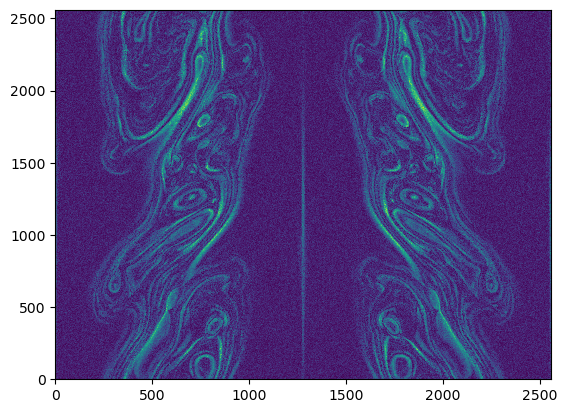

In [ ]:
dsi = tb.load_vars(dirs, t, 'ion')
jz_per = flip2D(ds['jz'] + dsi['jz'])
jx = (ds['jx'] + dsi['jx'])
jy = (ds['jy'] + dsi['jy'])
jz = (ds['jz'] + dsi['jz'])
j = np.sqrt(jx**2 + jy**2 + jz**2)
j_per = flip2D(j)
plt.pcolormesh(j_per.T)

In [ ]:
dbx_per = flip2D(dbx)
dby_per = flip2D(dby)
dbz_per = flip2D(dbz)

In [ ]:
def Euspec_prep(tin):
  t = times[tin]
  print(twci[tin])
  ds = tb.load_hydro_fil(dirs, t, 'ion')

  ux = ds['jx']/ds['rho']
  uy = ds['jy']/ds['rho']
  uz = ds['jz']/ds['rho']

  dux = ux - np.mean(ux)
  duy = uy - np.mean(uy)
  duz = uz - np.mean(uz)

  dux = flip2D(dux)
  duy = flip2D(duy)
  duz = flip2D(duz)
  # k, fft = tb.EuSpec2D(dux, duy, duz, lx = lx_de, ly = ly_de)
  k, fftx = PerpSpectrum(dux, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, ffty = PerpSpectrum(duy, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, fftz = PerpSpectrum(duz, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  fft = fftx + ffty + fftz
  return k, fft

def Ebspec_prep(tin):
  t = times[tin]
  ds = tb.load_fields(dirs, t)
  print(twci[tin])
  dbx = ds['cbx'] - np.mean(ds['cbx'])
  dby = ds['cby'] - np.mean(ds['cby'])
  dbz = ds['cbz'] - np.mean(ds['cbz'])
  dex = ds['ex'] - np.mean(ds['ex'])
  dey = ds['ey'] - np.mean(ds['ey'])
  dez = ds['ez'] - np.mean(ds['ez'])
  dbx_per = flip2D(dbx)
  dby_per = flip2D(dby)
  dbz_per = flip2D(dbz)
  # dex_per = flip2D(dex)
  # dey_per = flip2D(dey)
  # dez_per = flip2D(dez)
  # k, fft = tb.EbSpec2D(dbx_per, dby_per, dbz_per, dex_per, dey_per, dez_per, lx = lx_de, ly = ly_de)
  # PerpSpectrum(ar,sumax=2,lenx=2*np.pi,leny=2*np.pi,lenz=2*np.pi):
  k, fftx = PerpSpectrum(dbx_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, ffty = PerpSpectrum(dby_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, fftz = PerpSpectrum(dbz_per, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  fft = fftx + ffty + fftz
  return k, fft

In [ ]:
# k0, fft0 = Ebspec_prep(100)
# k1, fft1 = Ebspec_prep(290)
# k2, fft2 = Ebspec_prep(510)
# k3, fft3 = Ebspec_prep(657)
# k4, fft4 = Ebspec_prep(1124)

# window = 3
# fft0_av = pd.Series(fft0).rolling(window, center = True).mean()
# fft1_av = pd.Series(fft1).rolling(window, center = True).mean()
# fft2_av = pd.Series(fft2).rolling(window, center = True).mean()
# fft3_av = pd.Series(fft3).rolling(window, center = True).mean()
# fft4_av = pd.Series(fft4).rolling(window, center = True).mean()

In [ ]:
# df = pd.DataFrame({'k' : k0,
#                    'b0' : fft0,
#                    'b1' : fft1,
#                    'b2' : fft2,
#                    'b3' : fft3,
#                    'b4' : fft4,
#                    })
# df.to_csv(dirs + '/data/bfft.csv')
bk = pd.read_csv(dirs + '/data/bfft_fil.csv', index_col = 0)
window = 2
k_av = pd.Series(bk['k']).rolling(window, center = True).mean()
bk0_av = pd.Series(bk['b0']).rolling(window, center = True).mean()
bk1_av = pd.Series(bk['b1']).rolling(window, center = True).mean()
bk2_av = pd.Series(bk['b2']).rolling(window, center = True).mean()
bk3_av = pd.Series(bk['b3']).rolling(window, center = True).mean()
bk4_av = pd.Series(bk['b4']).rolling(window, center = True).mean()

In [ ]:
# dx = info['dx/de']
# dy = info['dy/de']
# dz = info['dz/de']
# lz = info['Lz/de']

In [ ]:
# ###B Parsavel's Thm
# t = 290
# ds = tb.load_fields(dirs, times[t])
# bx = ds['cbx'] - np.mean(ds['cbx'])
# by = ds['cby'] - np.mean(ds['cby'])
# bz = ds['cbz'] - np.mean(ds['cbz'])

# E_m = (1/2) * np.sum(bx**2 + by**2 + bz**2) * dx * dy/(lx_de * ly_de)
# k1, fft1 = Ebspec_prep(t)
# E_k = np.sum(fft1)

# print(E_m, E_k)
# print(E_m/E_k)

In [ ]:
# ###Ui Parsavel's Thm
# t = 290
# ds = tb.load_hydro(dirs, times[t], 'ion')

# ux = ds['jx']/ds['rho']
# uy = ds['jy']/ds['rho']
# uz = ds['jz']/ds['rho']

# dux = ux - np.mean(ux)
# duy = uy - np.mean(uy)
# duz = uz - np.mean(uz)

# dux = flip2D(dux)
# duy = flip2D(duy)
# duz = flip2D(duz)

# E_Ui = (1/2) * (1/2) * np.sum(dux**2 + duy**2 + duz**2) * dx * dy/(lx_de * ly_de)
# # E1_real = (1/2) * np.sum((bx**2 + by**2 + bz**2)/2)/(2 * info['nx'] * info['ny'])
# uk1, asdf = tb.EuSpec2D(dux, duy, duz, lx = lx_de, ly = ly_de)
# E_Uk = np.sum(asdf) 

# print(E_Ui, E_Uk)
# print(E_Ui/E_Uk)

In [ ]:
# print(ds['rho'])

In [ ]:
x1 = np.linspace(0.4, 1, 200)
y1 = 2 * 10**(-5) * x1**(-8/3)

x3 = np.linspace(1, 5, 200)
y3 = y1[-1]  * x3**(-4)

In [ ]:
ts = [100,290, 510, 657, 1124]

In [ ]:
uk0, ufft0 = Euspec_prep(100)
# uk1, ufft1 = Euspec_prep(290)
# uk2, ufft2 = Euspec_prep(510)
# uk3, ufft3 = Euspec_prep(657)
# uk4, ufft4 = Euspec_prep(1124)

# df = pd.DataFrame({'k' : uk0,
#                    'u0' : ufft0,
#                    'u1' : ufft1,
#                    'u2' : ufft2,
#                    'u3' : ufft3,
#                    'u4' : ufft4,
#                    })
# df.to_csv(dirs + '/data/uifft.csv')

# ufft0_av = pd.Series(ufft0).rolling(window, center = True).mean()
# ufft1_av = pd.Series(ufft1).rolling(window, center = True).mean()
# ufft2_av = pd.Series(ufft2).rolling(window, center = True).mean()
# ufft3_av = pd.Series(ufft3).rolling(window, center = True).mean()
# ufft4_av = pd.Series(ufft4).rolling(window, center = True).mean()

13.810680000000003


In [ ]:
k1_av = pd.Series(uk0).rolling(window, center = True).mean()
uk0_av1 = pd.Series(ufft0).rolling(window, center = True).mean()

In [ ]:

uk = pd.read_csv(dirs + '/data/uifft_fil.csv', index_col = 0)
window = 2
k_av = pd.Series(uk['k']).rolling(window, center = True).mean()
uk0_av = pd.Series(uk['u0']).rolling(window, center = True).mean()
uk1_av = pd.Series(uk['u1']).rolling(window, center = True).mean()
uk2_av = pd.Series(uk['u2']).rolling(window, center = True).mean()
uk3_av = pd.Series(uk['u3']).rolling(window, center = True).mean()
uk4_av = pd.Series(uk['u4']).rolling(window, center = True).mean()

In [ ]:
print(uk['u0'])

0       4.784530e-34
1       1.333392e-02
2       1.744126e-05
3       1.024645e-03
4       8.585588e-06
            ...     
1275    1.981789e-14
1276    3.123117e-18
1277    7.135307e-15
1278    1.991598e-18
1279    7.940880e-16
Name: u0, Length: 1280, dtype: float64


In [ ]:
x1 = np.linspace(0.4, 1, 200)
y1 = 2 * 10**(-3) * x1**(-8/3)

x3 = np.linspace(1, 5, 200)
y3 = y1[-1]  * x3**(-4)

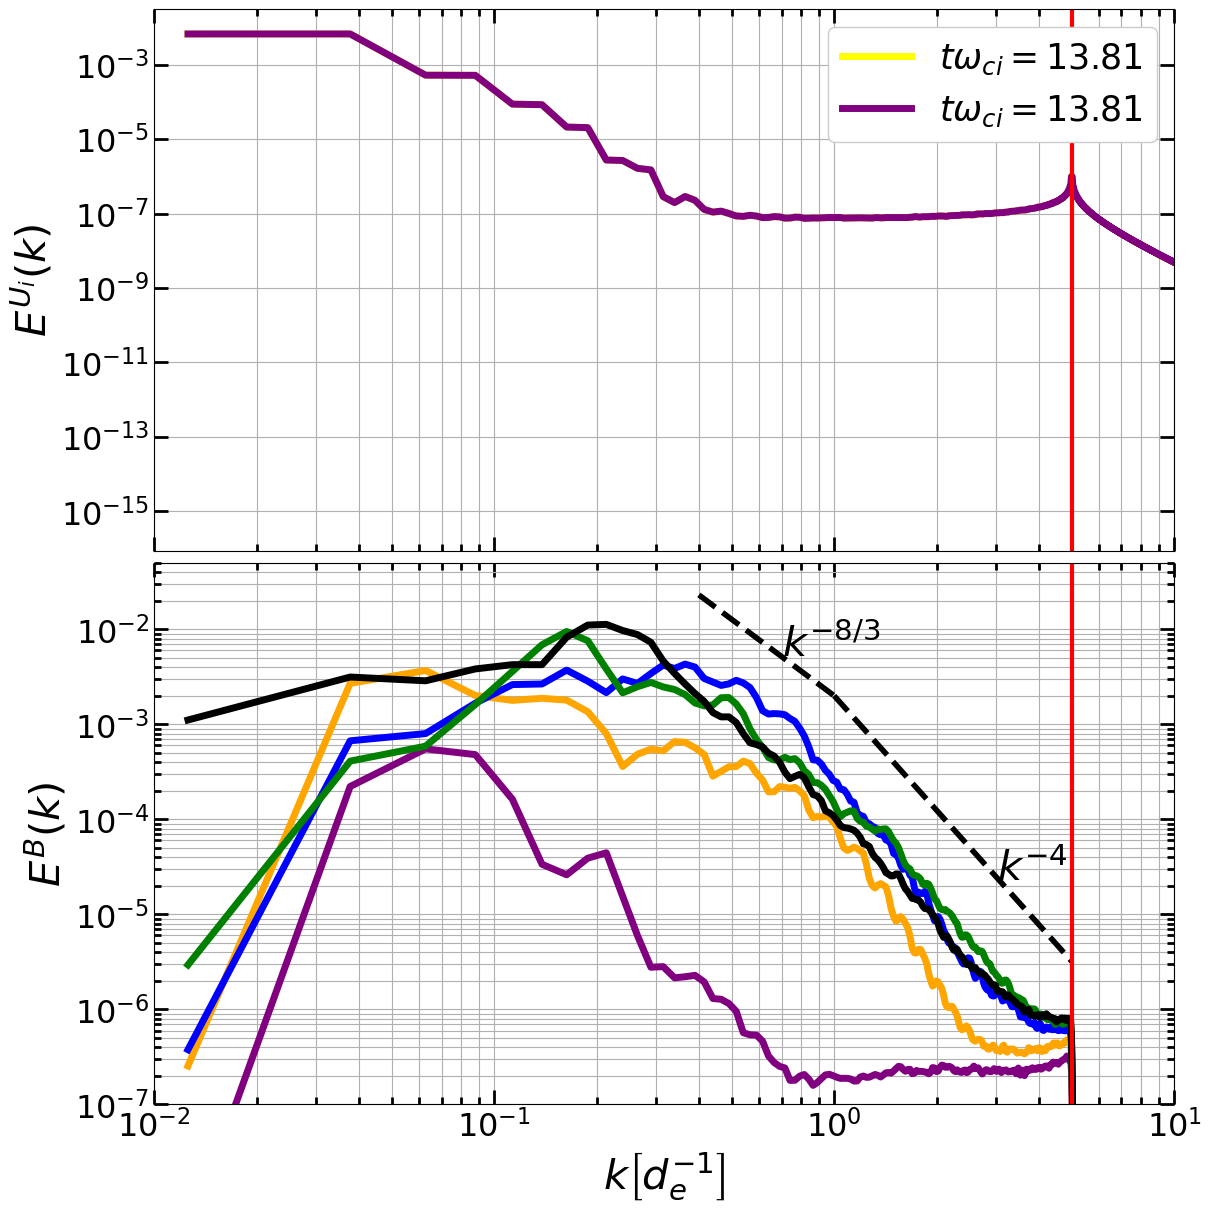

In [ ]:
mpl.rcParams['lines.linewidth'] = 3

fig, ax1 = plt.subplots(2, 1, figsize = (12,12), sharex = True, layout = 'constrained')


# ax1[0].loglog(uk['k'][1:], uk['u0'][1:], color = 'purple' , label = r'$t \omega_{ci} =$'f'{np.round(twci[100] ,2)}' ,linewidth = 5)
# ax1[0].loglog(uk['k'][1:], uk['u1'][1:], color = 'orange', label = r'$t \omega_{ci} = $'f'{ np.round(twci[290] ,2)}',linewidth = 5)
# ax1[0].loglog(uk['k'][1:], uk['u2'][1:], color = 'blue', label = r'$t \omega_{ci} = $'f'{ np.round(twci[510] ,2)}'  ,linewidth = 5)
# ax1[0].loglog(uk['k'][1:], uk['u3'][1:], color = 'green', label = r'$t \omega_{ci} =$'f'{np.round(twci[657] ,2)}'   ,linewidth = 5)
# ax1[0].loglog(uk['k'][1:], uk['u4'][1:], color = 'black', label = r'$t \omega_{ci} =$'f'{np.round(twci[1124],2)}'   ,linewidth = 5)
ax1[0].loglog(k1_av,uk0_av1, color = 'yellow' , label = r'$t \omega_{ci} =$'f'{np.round(twci[100] ,2)}' ,linewidth = 5)
ax1[0].loglog(k_av, uk0_av, color = 'purple' , label = r'$t \omega_{ci} =$'f'{np.round(twci[100] ,2)}' ,linewidth = 5)
# ax1[0].loglog(k_av, uk1_av, color = 'orange', label = r'$t \omega_{ci} = $'f'{ np.round(twci[290] ,2)}',linewidth = 5)
# ax1[0].loglog(k_av, uk2_av, color = 'blue', label = r'$t \omega_{ci} = $'f'{ np.round(twci[510] ,2)}'  ,linewidth = 5)
# ax1[0].loglog(k_av, uk3_av, color = 'green', label = r'$t \omega_{ci} =$'f'{np.round(twci[657] ,2)}'   ,linewidth = 5)
# ax1[0].loglog(k_av, uk4_av, color = 'black', label = r'$t \omega_{ci} =$'f'{np.round(twci[1124],2)}'   ,linewidth = 5)
ax1[0].axvline(5, color = 'red')
ax1[0].tick_params(which='both', width=2, labelsize = 23, right = True, direction = 'in')
ax1[0].tick_params(which='major', length=10, top = True, right =True)
ax1[0].tick_params(which='minor', length=5 , top = True, right =True)
# ax1[0].set_ylim(1 * 10**(-8), 1 * 10**(-2))
ax1[0].set_ylabel(r'$E^{U_i} (k)$', size  = 30)
ax1[0].grid(which = 'both')
ax1[0].legend(loc = 'upper right', fontsize = 25, framealpha = 1)


# ax1[1].loglog(bk['k'][1:], bk['b0'][1:], color = 'purple' , label = r'$t \omega_{ci} =$'f'{np.round(twci[100] ,2)}' ,linewidth = 5)
# ax1[1].loglog(bk['k'][1:], bk['b1'][1:], color = 'orange', label = r'$t \omega_{ci} = $'f'{ np.round(twci[290] ,2)}',linewidth = 5)
# ax1[1].loglog(bk['k'][1:], bk['b2'][1:], color = 'blue', label = r'$t \omega_{ci} = $'f'{ np.round(twci[510] ,2)}'  ,linewidth = 5)
# ax1[1].loglog(bk['k'][1:], bk['b3'][1:], color = 'green', label = r'$t \omega_{ci} =$'f'{np.round(twci[657] ,2)}'   ,linewidth = 5)
# ax1[1].loglog(bk['k'][1:], bk['b4'][1:], color = 'black', label = r'$t \omega_{ci} =$'f'{np.round(twci[1124],2)}'   ,linewidth = 5)
ax1[1].loglog(k_av, bk0_av, color = 'purple' , label = r'$t \omega_{ci} =$'f'{np.round(twci[100] ,2)}' ,linewidth = 5)
ax1[1].loglog(k_av, bk1_av, color = 'orange', label = r'$t \omega_{ci} = $'f'{ np.round(twci[290] ,2)}',linewidth = 5)
ax1[1].loglog(k_av, bk2_av, color = 'blue', label = r'$t \omega_{ci} = $'f'{ np.round(twci[510] ,2)}'  ,linewidth = 5)
ax1[1].loglog(k_av, bk3_av, color = 'green', label = r'$t \omega_{ci} =$'f'{np.round(twci[657] ,2)}'   ,linewidth = 5)
ax1[1].loglog(k_av, bk4_av, color = 'black', label = r'$t \omega_{ci} =$'f'{np.round(twci[1124],2)}'   ,linewidth = 5)
ax1[1].loglog(x1, y1, linewidth = 4, linestyle = '--', color = 'black')
ax1[1].loglog(x3, y3, linewidth = 4, linestyle = '--', color = 'black')
ax1[1].axvline(5, color = 'red')
ax1[1].tick_params(which='both', width=2, labelsize = 23, right = True, direction = 'in')
ax1[1].tick_params(which='major', length=10, top = True, right =True)
ax1[1].tick_params(which='minor', length=5 , top = True, right =True)

plt.text(x1[100], y1[100], r'$k^{-8/3}$', size = 30)
plt.text(x3[100], y3[102], r'$k^{-4}$', size = 30)

ax1[1].set_ylabel(r'$E^B (k)$', size  = 30)
ax1[1].set_xlabel(r'$k  \left[ d_e^{-1}    \right]$', size = 30)
ax1[1].set_xlim(1 * 10**(-2), 1 * 10**(1))
ax1[1].set_ylim(1 * 10**(-7), 5 * 10**(-2))
ax1[1].grid(which = 'both')
# ax1[1].legend(loc = 'upper right', fontsize = 20)
fig.savefig(figs + f'spectrum_twci.png')

In [ ]:
def read_calc_energies(dirs, filt = True):
  if filt == True:
    fdata = pd.read_csv(dirs + 'en_calc_fil.csv')
  else:
    fdata = pd.read_csv(dirs + 'en_calc.csv')
  

  en_dict = {}
  en_dict['EE'] = fdata['EE']
  en_dict['EM'] = fdata['EM']

  en_dict['Ethi'] = fdata['Ethi']
  en_dict['Efi'] = fdata['Efi']
  en_dict['Ei'] = fdata['Efi'] + fdata['Ethi']

  en_dict['Ethe'] = fdata['Ethe']
  en_dict['Efe'] = fdata['Efe']
  en_dict['Ee']  = fdata['Efe'] + fdata['Ethe']
  
  en_dict['Et'] = fdata['Et']
  return pd.DataFrame(en_dict)

In [ ]:
en = read_calc_energies(dirs, filt = False)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

(1e-08, 0.01)

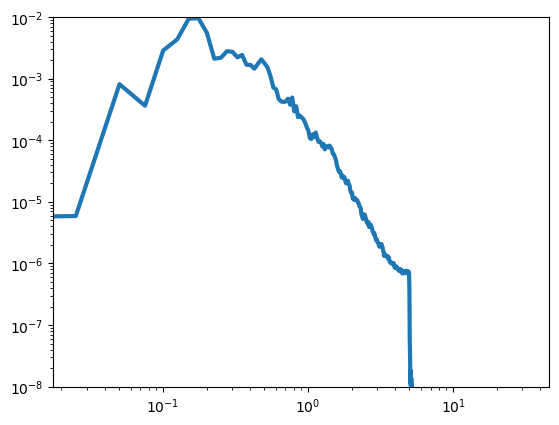

In [ ]:
fft = pd.read_csv(dirs + 'data/bfft_fil.csv')
plt.loglog(fft['k'], fft['b3'])
plt.ylim(10**(-8), 10**(-2))

In [ ]:
t = ts[4]
print(t)
ds = tb.load_field_fil(dirs, times[t])
bx = ds['cbx'] - np.mean(ds['cbx'])
by = ds['cby'] - np.mean(ds['cby'])
bz = ds['cbz'] - np.mean(ds['cbz'])
dk = fft['k'][1] - fft['k'][0]
E_m = np.sum(bx**2 + by**2 + bz**2)/(nx * ny)
E_k = np.sum(fft['b4']) * dk
print(E_m, E_k)
print(E_m/E_k)
print((E_m-E_k))

1124
0.002663245969589146 0.002598013868817388
1.0251084497872414
6.523210077175783e-05


(1e-08, 0.01)

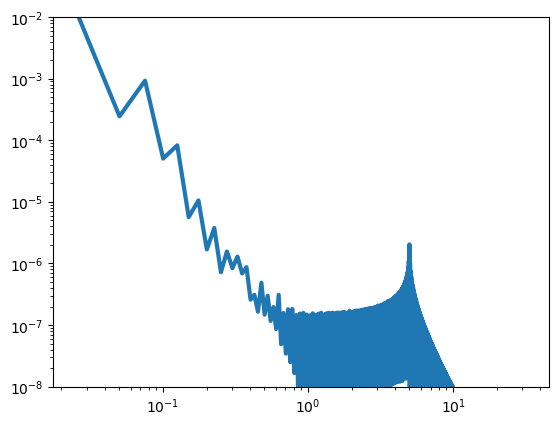

In [ ]:
ufft = pd.read_csv(dirs + 'data/uifft_fil.csv')
plt.loglog(ufft['k'], ufft['u1'])
plt.ylim(10**(-8), 10**(-2))

In [ ]:
t = ts[3]
print(t)
ds = tb.load_hydro_fil(dirs, times[t], 'ion')
dk = ufft['k'][1] - ufft['k'][0]
ux = ds['jx']/ds['rho']
uy = ds['jy']/ds['rho']
uz = ds['jz']/ds['rho']

dux = ux - np.mean(ux)
duy = uy - np.mean(uy)
duz = uz - np.mean(uz)

E_Ui = np.sum(dux**2 + duy**2 + duz**2)/(nx * ny)
E_Uik = np.sum(ufft['u3']) * dk
print(E_Ui, E_Uik)
print(E_Ui/E_Uik)
print((E_Ui-E_Uik))

657
0.00043117699942414383 0.00030667733577914065
1.4059630403684735
0.00012449966364500318


In [ ]:
%load_ext cython